<a href="https://colab.research.google.com/github/rajdeepbanerjee-git/JNCLectures_Intro_to_ML/blob/main/Week4/Lec4_LinReg_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference of the examples can be found in the book "Hands-on machine learning with Scikit-Learn, Keras and TensorFlow" by Aurelien Geron.


In [1]:
import sklearn
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#### The normal equation and closed form solution:
As we discussed in the last class, the closed form solution to y=Theta*X is given by Theta_cap = (X_T*X)^-1 *X_T*y.
Where, X_T = Transpose(X)



Text(0, 0.5, '$y$')

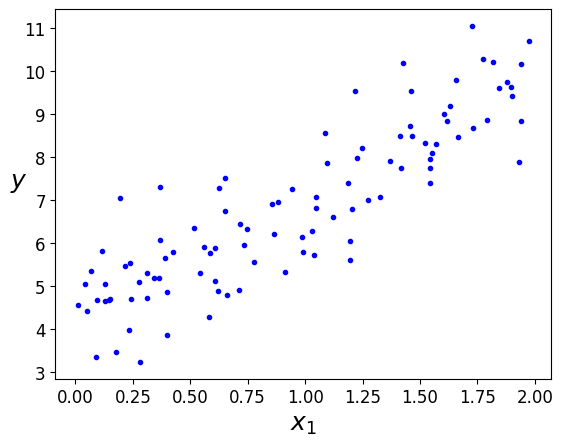

In [2]:
# Let's generate some dummy data to work on ...

X = 2 * np.random.rand(100, 1) # so, we know that the min and max values of X are 0, 2
y = 4 + 3 * X + np.random.randn(100, 1)

# plot
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)

Remember, to include the constant term (Theta*X + b), we add a constant 1 column to X

In [3]:
# Note: np.c_() lets you concatenate vectors. Here we add x0 = 1 to each instance using c_()
X_b = np.c_[np.ones((100, 1)), X]
print("before adding: \n", X[0:5])
print("after adding: \n", X_b[0:5])


before adding: 
 [[0.74908024]
 [1.90142861]
 [1.46398788]
 [1.19731697]
 [0.31203728]]
after adding: 
 [[1.         0.74908024]
 [1.         1.90142861]
 [1.         1.46398788]
 [1.         1.19731697]
 [1.         0.31203728]]


Now, the closed form solution ...

In [4]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.21509616],
       [2.77011339]])

Now, let's use the calculated parameters to predict for new values of X


In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
print(X_new_b)
y_predict = X_new_b.dot(theta_best)
print(y_predict)

[[1. 0.]
 [1. 2.]]
[[4.21509616]
 [9.75532293]]


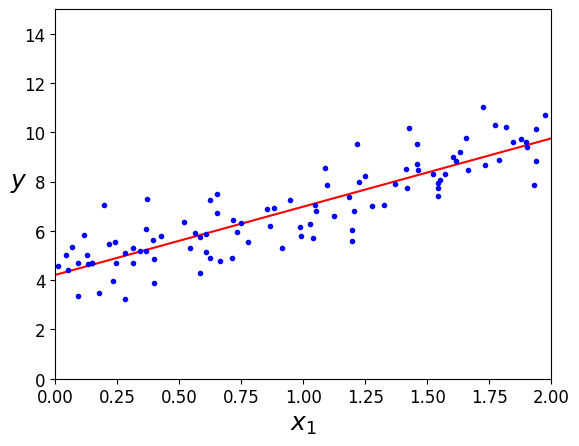

In [6]:
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

Let's try the same with sklearn model ...

In [7]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [8]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

Internally, they use the same closed form solution where the inverse is actually a pseudo-inverse or a [Moore-Penrose inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse).

#### The batch gradient descent:
1. Take the whole training data
2. compute gradient of loss
3. update parameters
4.  predict and calulate loss
5.  repeat step 2-4 n times

In [9]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)  # random initialization of weight and bias

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [10]:
theta

array([[4.21509616],
       [2.77011339]])

In [11]:
# new prediction
X_new_b.dot(theta)

array([[4.21509616],
       [9.75532293]])

###### Effect of learning rate:
- very low (eta = 0.02): takes a lot of iteration to reach best fit
- very high (eta = 0.5): may bounce around and never reach solution

In [12]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    # for each iteration I will calculate theta and predict on X_new_b using that
    for iteration in range(n_iterations):
        # the plot is shown only for the first 10 iterations
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

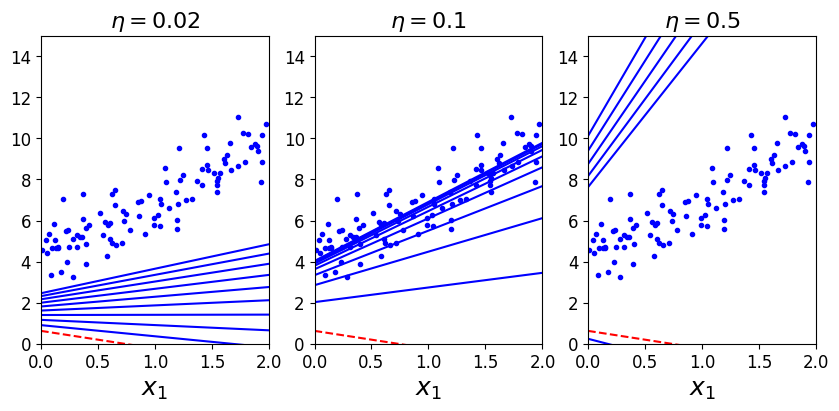

In [14]:
theta = np.random.randn(2,1)  # random initialization
plt.figure(figsize=(10,4))

# iterate over eta values and plot for each eta
for i, eta in enumerate([0.02, 0.1, 0.5]):
  plt.subplot(1, 3, i+1)
  plot_gradient_descent(theta, eta=eta)

plt.show()

#### Stochastic gradient descent
- The gradient is calculated on each point chosen randomly (hence stochastic)
- We update for each data point (m data points) for each epoch (n_epoch)
- Since the gradient is calculated for each point, the time taken is lower
- But, now you are doing an update for n_epoch*m times
- The optimization process is jittery because of the stochastic nature:
  - Pros: Useful to move out of a local minima
  - Cons: May never settle at the minimum. Use a "scheduler" to reduce the learning rate slowly so that near the minimum it settles slowly.

In [15]:
theta_path_sgd = [] # to store theta values for each step
m = len(X_b) # number of observations or data points

<ipython-input-16-9946647d0724>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(X_new, y_predict, style, color=color)
<ipython-input-16-9946647d0724>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(X_new, y_predict, style, color=color)


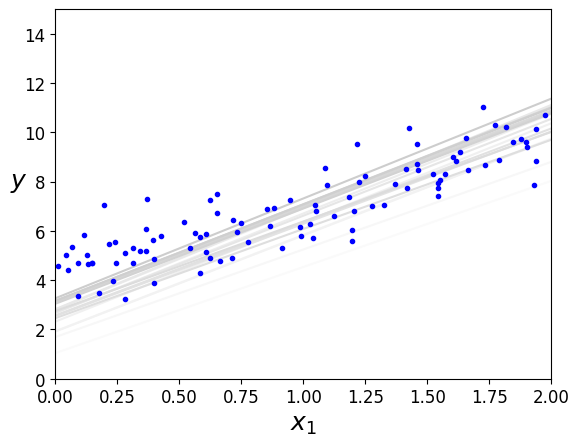

In [16]:
n_epochs = 1
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            color_intensity = 1 - (i+1)/(m+1)
            color = [color_intensity, color_intensity, color_intensity]
            plt.plot(X_new, y_predict, style, color=color)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

In [17]:
theta

array([[3.95728856],
       [2.9523521 ]])

#### Do it yourself:
Increase n_epoch to 50 and plot the theta values vs. epoch.


#### Mini-batch gradient descent:
To reduce the erratic behaviour of stochastic gradient descent, due to so many gradient updates, we strike a balance between batch and stochastic gradient descent:
- calculate gradients on small random batches
- update m/batch_size number of times in each epoch

In [18]:
theta_path_mgd = []

n_iterations = 1
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [ ]:
theta

array([[3.71429388],
       [3.20349372]])

#### Do it yourself:
Increase n_epoch to 50 and plot the theta values vs. epoch.

How do the plots for stochastic and mini-batch gradient descent compare?